In [1070]:
import requests
import pickle
import pandas as pd
import json as js
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from sklearn.cluster import KMeans
from matplotlib.dates import DateFormatter, date2num
import plotly.express as px
import math

In [96]:
players_df = pd.concat(map(pd.read_csv, ['players_df_500.csv', 'players_df_1082.csv']))
teams_df = pd.concat(map(pd.read_csv, ['teams_df_500.csv', 'teams_df_1082.csv']))
teams_df = teams_df.drop_duplicates()
teams_df = teams_df.sort_values('id')
games_df = pd.concat(map(pd.read_csv, ['games_df_500.csv', 'games_df_1082.csv']))
#events_df = pd.read_csv('events_df.csv')
#players_df
#teams_df
#games_df

In [779]:
events_df = pd.concat(map(pd.read_csv, ['events_df_500.csv', 'events_df_1082.csv']))

In [780]:
#Nullas sorok feltoltese hogy utana int-re valtoztathassuk
events_df = events_df.fillna(0)
events_df = events_df.astype({'player1Id': 'int64','player2Id':'int64','player3Id':'int64','player4Id':'int64'})
#Distinct jatek datumok uj dataframebe
date_df =  games_df.loc[:,['pk','startDate']]
#Ramergeljuk az events_df-re
events_df = pd.merge(left=events_df, right=date_df, left_on='gameId', right_on='pk', how='left')
events_df = events_df.drop(columns=['pk'])
#A datum vegerol levagjuk a felesleges reszt
events_df['startDate'] = events_df['startDate'].str[:10]
#A periodTime konvertalasa Timedelta tipusra
events_df['periodTimeFull'] = pd.to_timedelta(events_df['periodTime'].apply(lambda x: f'00:{x}'))
#periodtime atszamitasa teljes idotartamra a 3x20 perc helyett (NOTE: sokaig tart es hibat is ir de megcsinalja)
for idx, i in enumerate(events_df['period']):
    if i==1:
        #print(i, sog_df['coY'].iloc[idx])
        events_df['periodTimeFull'].iloc[idx] = events_df['periodTimeFull'].iloc[idx]
    elif i==2:
        events_df['periodTimeFull'].iloc[idx] = events_df['periodTimeFull'].iloc[idx]+'00:20:00'
    elif i==3:
        events_df['periodTimeFull'].iloc[idx] = events_df['periodTimeFull'].iloc[idx]+'00:40:00'
#Kerekitjuk percekre
events_df['periodTimeFull'] = events_df['periodTimeFull'].dt.round('60s')

In [1161]:
#events_df.dtypes
#events_df[300:]

In [6]:
#Data Exploratory: Atlagos eletkor
avg_age = pd.DataFrame()
avg_age = round(players_df.groupby('teamID')['currentAge'].mean(),1).sort_values()
teamsname = teams_df[['id','name']]
agebyteams = pd.merge(left=avg_age, right=teamsname, left_on='teamID', right_on='id', how='left')
agebyteams

,currentAge,id,name
0,28.2,3,New York Rangers
1,28.3,12,Carolina Hurricanes
2,28.3,7,Buffalo Sabres
3,28.3,29,Columbus Blue Jackets
4,28.4,52,Winnipeg Jets
5,28.7,1,New Jersey Devils
6,28.7,10,Toronto Maple Leafs
7,28.8,21,Colorado Avalanche
8,29.1,24,Anaheim Ducks
9,29.2,4,Philadelphia Flyers


Text(0.5, 0, 'Kor')

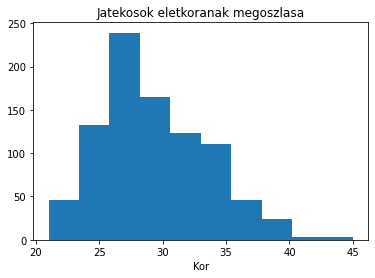

In [95]:
#Data Exploratory: Atlagos eletkor histogram
playersage = players_df[['id','currentAge']]
playersage = playersage.drop_duplicates()
playersage = playersage.drop(columns=['id'])
plt.hist(playersage)
plt.title('Jatekosok eletkoranak megoszlasa')
plt.xlabel('Kor')

In [1094]:
#Uj dataframe meghatarozott ember meghatarozott esemenyeivel
sog_df = pd.DataFrame()
sog_df = events_df[events_df['eventType'].isin(['Goal'])]
sog_df = sog_df[sog_df['player1Id'].isin([8471214])]
sog_df = sog_df.drop_duplicates()
sog_df = sog_df.astype({'coX': 'int64','coY':'int64'})

#Tukrozzuk az esemenyeket az origora
for idx, i in enumerate(sog_df['coX']):
    if i<0:
        sog_df['coX'].iloc[idx] = abs(sog_df['coX'].iloc[idx])
        sog_df['coY'].iloc[idx] = sog_df['coY'].iloc[idx]*-1
        
#Shot distance and angle
goalcenter_x = 89
goalcenter_y = 0

sog_df['shot_angle'] = sog_df[['coX','coY']].apply(
    lambda row: np.arctan(row['coY']/(89-row['coX']))*(180/np.pi),
    axis=1)

sog_df['shot_distance'] = sog_df[['coX','coY']].apply(
    lambda row: np.sqrt((row['coX']-goalcenter_x)**2 + (row['coY']-goalcenter_y)**2), axis=1)

sog_df

,gameId,eventId,eventType,eventTypeDesc,period,periodTime,periodType,teamAwayID,teamHomeID,goalsHome,...,player1Id,player1Type,player2Id,player2Type,player3Id,player3Type,player4Id,player4Type,startDate,periodTimeFull
448,2019020002,66,Goal,"Alex Ovechkin (1) Snap Shot, assists: John Car...",1,15:37,REGULAR,15,19,2,...,8471214,Scorer,8474590,Assist,8474189,Assist,8476412,Goalie,2019-10-03,0 days 00:16:00
16743,2019020052,124,Goal,"Alex Ovechkin (2) Slap Shot, assists: John Car...",2,04:46,REGULAR,15,18,1,...,8471214,Scorer,8474590,Assist,8475744,Assist,8471469,Goalie,2019-10-11,0 days 00:25:00
16802,2019020052,183,Goal,"Alex Ovechkin (3) Slap Shot, assists: John Car...",2,17:36,REGULAR,15,18,2,...,8471214,Scorer,8474590,Assist,8473563,Assist,8471469,Goalie,2019-10-11,0 days 00:38:00
22769,2019020070,326,Goal,"Alex Ovechkin (4) Backhand, assists: Tom Wilso...",3,19:03,REGULAR,15,25,1,...,8471214,Scorer,8476880,Assist,0,0,0,0,2019-10-13,0 days 00:59:00
26880,2019020083,312,Goal,"Alex Ovechkin (5) Slap Shot, assists: Evgeny K...",3,17:39,REGULAR,21,15,3,...,8471214,Scorer,8475744,Assist,8474590,Assist,8475831,Goalie,2019-10-14,0 days 00:58:00
40599,2019020126,247,Goal,"Alex Ovechkin (6) Wrist Shot, assists: John Ca...",3,03:52,REGULAR,15,16,1,...,8471214,Scorer,8474590,Assist,8479482,Assist,8470645,Goalie,2019-10-20,0 days 00:44:00
45460,2019020142,195,Goal,"Alex Ovechkin (7) Snap Shot, assists: Nicklas ...",2,16:35,REGULAR,15,20,2,...,8471214,Scorer,8473563,Assist,8475462,Assist,8475660,Goalie,2019-10-23,0 days 00:37:00
49181,2019020154,155,Goal,"Alex Ovechkin (8) Tip-In, assists: Jonas Siege...",2,06:27,REGULAR,15,22,1,...,8471214,Scorer,8478399,Assist,8474590,Assist,8475156,Goalie,2019-10-25,0 days 00:26:00
49223,2019020154,197,Goal,"Alex Ovechkin (9) Snap Shot, assists: Tom Wils...",2,13:40,REGULAR,15,22,1,...,8471214,Scorer,8476880,Assist,8477944,Assist,8475156,Goalie,2019-10-25,0 days 00:34:00
57478,2019020180,242,Goal,"Alex Ovechkin (10) Snap Shot, assists: T.J. Os...",3,04:10,REGULAR,15,10,3,...,8471214,Scorer,8471698,Assist,8473563,Assist,8475883,Goalie,2019-10-29,0 days 00:44:00


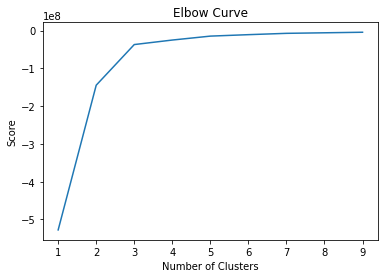

In [23]:
#Meghatarozzuk, hany klaszter erdemes letrehozni a koordinatakra (a konyokpont erteke kell nekunk, ahonnan mar
#nem novekszik tovabb lavanyosan a fgv.)
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = events_df[['coX']]
X_axis = events_df[['coY']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [726]:
#Letrehozunk egy uj dataframet a vizualizaciohoz az x es y koordinatakkal
X = sog_df.loc[:,['coX','coY']]

X_round = sog_df.loc[:,['coX','coY']]

#Uj dataframe, szamok kerekitve a masodik fajta vizualizaciohoz, hogy a szinek jol nezzenek ki:
for idx, i in X_round.iterrows():
    X_round.loc[idx,'coX'] = (round(X_round.loc[idx,'coX']/5.0)*5.0)
    X_round.loc[idx,'coY'] = (round(X_round.loc[idx,'coY']/5.0)*5.0)
#X
#X_round

,coX,coY
448,57,-18
16743,53,22
16802,60,20
22769,4,-34
26880,34,-7
40599,61,10
45460,63,19
49181,68,11
49223,73,13
57478,81,8


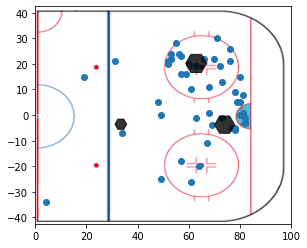

In [683]:
#A meghatarozott klaszterszamot megadva klaszterekbe soroljuk a koordinatakat
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(X[X.columns[0:2]]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[X.columns[0:2]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[X.columns[0:2]]) # Labels of each point
#X

#Kiszamoljuk a pottyok meretet, a klaszterek elemszamat vesszuk es megszorozzuk valamennyiel, hogy nagyobb legyen.
size = X.groupby(['cluster_label']).count()
size = size['coX']*20

#Ket valtozot inicializalunk aminek megadjuk az X es Y oszlopunkat, hogy kesobb be tudjuk taplalni a plot-ba
coX = X['coX']
coY = X['coY']
img = plt.imread("Half_ice_hockey_rink.png")
fig, ax = plt.subplots()
ax.imshow(img, extent=[0, 100, -42.5, 42.5])
ax.scatter(coX, coY)
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=size, marker='H', alpha=0.8)
plt.xlim(0,100)
plt.ylim(-42.5,42.5)
plt.show()

In [409]:
#Goal - Assist pairs
Y = sog_df.loc[:,['player1Id','player2Id']]
Y = Y.groupby(['player1Id', 'player2Id']).size().sort_values(ascending=False).reset_index(name='count') 
Y

,player1Id,player2Id,count
0,8471214,8474590,14
1,8471214,8475744,8
2,8471214,8473563,6
3,8471214,8475200,6
4,8471214,8476880,5
5,8471214,8471698,4
6,8471214,0,1
7,8471214,8469454,1
8,8471214,8476316,1
9,8471214,8477424,1


In [707]:
df_counts = X_round.groupby(['coY', 'coX']).size().reset_index(name='counts')
df_counts['Number of events'] = df_counts['counts'] * 2

fig = px.scatter(df_counts, x='coX', y='coY',
                 color='Number of events',
                 size='Number of events',
                 width=685, height=580)
fig.update_layout(yaxis_range=[-42.5,42.5])
fig.update_layout(xaxis_range=[0,100])

# Remove side scale and hide zero and gridlines
fig.update_layout(
    coloraxis_showscale=True,
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False),)
# Disable axis ticks and labels
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.update_xaxes(title_text='')
fig.update_yaxes(title_text='')

fig.add_layout_image(
        dict(
            source='Half_ice_hockey_rink.png',
            xref="x",
            yref="y",
            x=0,
            y=42,
            sizex=100,
            sizey=85,
            sizing="stretch",
            opacity=0.5,
            layer="below")
)

fig.update_layout(template="plotly_white")

fig.show()

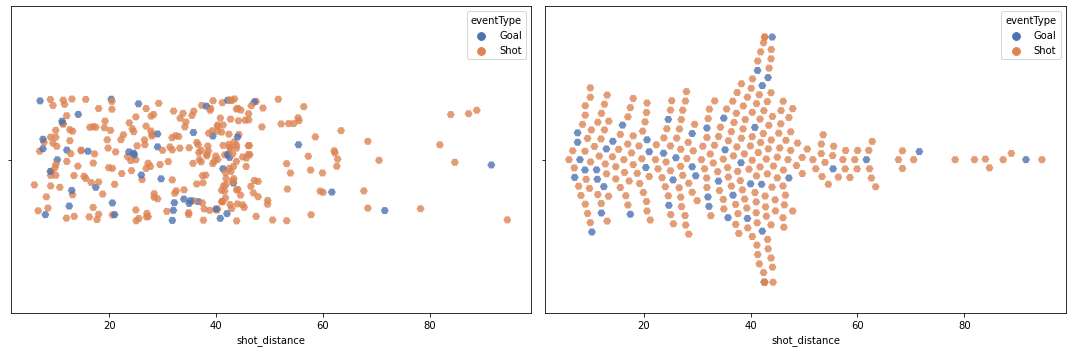

In [618]:
dist = pd.DataFrame()
dist = sog_df[['shot_distance','player1Id','eventType']]

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

sb.stripplot(data=dist, x=dist['shot_distance'], y=[""]*len(dist), ax=ax1, hue=dist['eventType'],palette="deep", 
             size=8, marker="H", edgecolor="gray", alpha=.8, jitter = .2)

sb.swarmplot(data=dist, x=dist['shot_distance'], ax=ax2,  y=[""]*len(dist), hue=dist['eventType'],palette="deep", 
             size=8, marker="H",edgecolor="gray", alpha=.8)

plt.tight_layout()

In [632]:
#events_df.player1Type.unique() #'Winner', 'Scorer', 'Shooter', 'PenaltyOn', 'PlayerID','Blocker', 'Hitter'
#events_df.player2Type.unique() #'Loser', 'Assist', 'DrewBy', 'Goalie', 'Shooter', 'Hittee' (Blocked Shot-nal elso a Blocker masodik a Shooter)
#events_df.player3Type.unique() #'Assist', 'Goalie', 'ServedBy'
#events_df.player4Type.unique() #'Golie'
events_df.eventType.unique()

array(['Game Scheduled', 'Period Ready', 'Period Start', 'Faceoff',
       'Goal', 'Missed Shot', 'Stoppage', 'Penalty', 'Giveaway', 'Shot',
       'Blocked Shot', 'Hit', 'Takeaway', 'Period End', 'Period Official',
       'Official Challenge', 'Game End', 'Game Official',
       'Shootout Complete', 'Early Intermission Start',
       'Early Intermission End', 'Emergency Goaltender'], dtype=object)

In [1158]:
#Elso DataFrame: osszes kapuraloves a player 1-tol
tmp_sog = events_df[['gameId','player1Id','startDate','eventType']]
tmp_sog = tmp_sog[tmp_sog['eventType'].isin(['Shot','Missed Shot','Goal'])]
tmp_sog_calc = tmp_sog.groupby(['gameId','startDate','player1Id']).count()
tmp_sog_calc = tmp_sog_calc.rename(columns={"eventType": "allShots"})
tmp_sog_calc.reset_index(inplace=True)
#tmp_sog_calc

#Masodik temp dataframe: osszes kapuraloves a player 2-tol (Blocked Shot)
tmp_sog_b = events_df[['gameId','player2Id','startDate','eventType']]
tmp_sog_b = tmp_sog_b[tmp_sog_b['eventType'].isin(['Blocked Shot'])]
tmp_sog_calc_b = tmp_sog_b.groupby(['gameId','startDate','player2Id']).count()
tmp_sog_calc_b = tmp_sog_calc_b.rename(columns={"eventType": "allShots"})
tmp_sog_calc_b.reset_index(inplace=True)
#tmp_sog_calc_b

#Harmadik temp DataFrame: Az osszes kapuraloves
tmp_allsog = pd.merge(left=tmp_sog_calc, right=tmp_sog_calc_b, 
                          left_on=['gameId','startDate','player1Id'], right_on=['gameId','startDate','player2Id'], 
                          how='left')
tmp_allsog = tmp_allsog.fillna(0)
tmp_allsog = tmp_allsog.astype({'allShots_y': 'int64'})
tmp_allsog['allShots'] = tmp_allsog['allShots_x']+tmp_allsog['allShots_y']
tmp_allsog = tmp_allsog.drop(columns=['allShots_x','player2Id','allShots_y'])
#tmp_allsog

#Negyedik temp DataFrame: Az osszes Goal
tmp_goal = events_df[['gameId','player1Id','startDate','eventType']]
tmp_goal = tmp_goal[tmp_goal['eventType'].isin(['Goal'])]
tmp_goal_calc = tmp_goal.groupby(['gameId','startDate','player1Id']).count()
tmp_goal_calc = tmp_goal_calc.rename(columns={"eventType": "allGoals"})
tmp_goal_calc.reset_index()

#Vegso DataFrame: Osszes kapuraloves es goal merge, szazalek szamitas
sog_percentage = pd.merge(left=tmp_allsog, right=tmp_goal_calc, 
                          left_on=['gameId','startDate','player1Id'], right_on=['gameId','startDate','player1Id'], 
                          how='left')

sog_percentage['sog%'] = round(((sog_percentage['allGoals']/sog_percentage['allShots'])*100),1)
sog_percentage["Date"] = pd.to_datetime(sog_percentage["startDate"])
sog_percentage.reset_index(inplace=True)
sog_percentage

,index,gameId,startDate,player1Id,allShots,allGoals,sog%,Date
0,0,2019020001,2019-10-02,8471676,7,1.0,14.3,2019-10-02
1,1,2019020001,2019-10-02,8473573,1,NaN,NaN,2019-10-02
2,2,2019020001,2019-10-02,8474162,4,NaN,NaN,2019-10-02
3,3,2019020001,2019-10-02,8474589,3,NaN,NaN,2019-10-02
4,4,2019020001,2019-10-02,8474697,3,NaN,NaN,2019-10-02
...,...,...,...,...,...,...,...,...
33422,33422,2019021082,2020-03-12,8480014,4,1.0,25.0,2020-03-12
33423,33423,2019021082,2020-03-12,8480113,4,NaN,NaN,2020-03-12
33424,33424,2019021082,2020-03-12,8480336,4,NaN,NaN,2020-03-12
33425,33425,2019021082,2020-03-12,8480801,5,NaN,NaN,2020-03-12


<AxesSubplot:xlabel='Date', ylabel='sog%'>

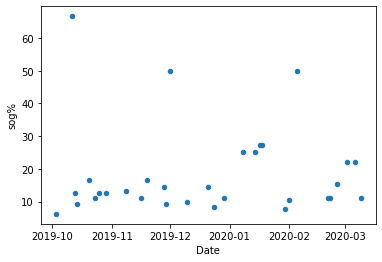

In [1159]:
#Egy jatekosra nezve:
sog_perc_oneplayer = sog_percentage[['Date','player1Id','allShots','allGoals','sog%']]
sog_perc_oneplayer = sog_perc_oneplayer[sog_perc_oneplayer['player1Id'].isin([8471214])]
sog_perc_oneplayer.plot(x='Date',y='sog%', kind='scatter')

/var/folders/z6/nzpwwscs6qj7t6gldff9vtlw0000gn/T/ipykernel_77575/1545891617.py:11: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



<AxesSubplot:xlabel='periodTimeFull'>

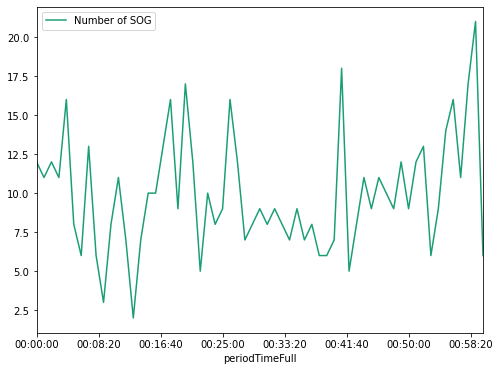

In [1160]:
#Timeline: X axis-on a 60 perc, esemenyeket percre kerekitem. A szezon osszes kapuralovese az adott percben adott embertol
#A kapuraloves lehet: 'Shot','Missed Shot','Goal' es 'Blocked Shot'. Blokkoltnal a Player2-n van logolva a Shooter

tmp_sog_time = events_df[['gameId','player1Id','startDate','eventType','periodTimeFull']]
tmp_sog_time = tmp_sog_time[tmp_sog_time['eventType'].isin(['Shot','Missed Shot','Goal'])]

tmp_sog_b_time = events_df[['gameId','player2Id','startDate','eventType','periodTimeFull']]
tmp_sog_b_time = tmp_sog_b_time[tmp_sog_b_time['eventType'].isin(['Blocked Shot'])]
tmp_sog_b_time = tmp_sog_b_time.rename(columns={"player2Id": "player1Id"})

timechart = tmp_sog_time.append(tmp_sog_b_time, ignore_index=True)

timechart = timechart[timechart['player1Id'].isin([8471214])]
timechart = timechart.groupby(['periodTimeFull']).count()
timechart = timechart.drop(columns=['gameId','player1Id','startDate'])
timechart = timechart.rename(columns={"eventType": "Number of SOG"})
timechart.reset_index(inplace=True)
timechart.plot(x='periodTimeFull', figsize=(8,6), cmap='Dark2')
#px.line(timechart, x="periodTimeFull", y="Number of SOG", title='# of SOG')
#timechart

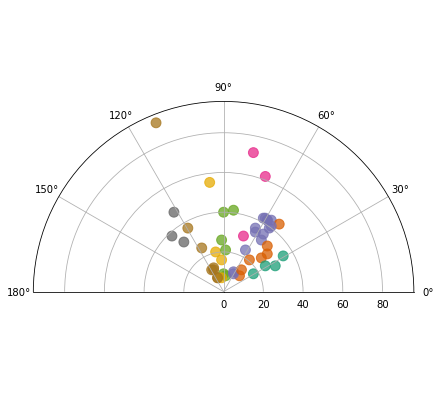

In [1151]:
#Szogek vizualizalasa
#Atszamoljuk radianra, aztan elforgatjuk hogy 0-180 kozott tudjam abrazolni
#sog_df['shot_angle'] = sog_df['shot_angle']*(math.pi/180)
#sog_df['shot_angle_vis'] = sog_df['shot_angle']*-1+(math.pi/2)

theta = sog_df['shot_angle_vis']
r = sog_df['shot_distance']
area = sog_df['shot_angle'].count()
colors = theta
size = sog_df['shot_angle_vis'].count()*2

fig = plt.figure()
ax = fig.add_subplot(projection='polar')
c = ax.scatter(theta, r, s=size, cmap='Dark2', c = colors, alpha=0.75)
plt.gcf().set_size_inches(8, 7)

ax.set_thetamin(0)
ax.set_thetamax(180)